In [1]:
import pandas as pd
import collections
import matplotlib as plt
import scipy
from scipy import stats
%matplotlib inline
import pandas as pd
pd.options.display.float_format = '{:,.1f}'.format


In [13]:
def load_data():
    cases = pd.read_excel('navdata/cases_occupation.xlsx') #from navaratnum uses soc 1990
    controls = pd.read_excel('navdata/controls_occupation.xlsx') #from navaratnum uses soc 1990
    sclass = pd.read_excel("./navdata/nssecderivationtablessoc90.xls")
    return cases, controls, sclass

def clean_list(messylist):
#cleans a list containing ranges by expanding ranges e.g 1-4 becomes 1,2,3,4. 
#like the ones we have in table 2.3.2 www.hse.gov.uk/research/rrpdf/rr696.pdf

    nums = []
    expandnums = []

    messylist = messylist.split(",")
    messylist = [s.strip() for s in messylist]

    for s in messylist:
        if '-' in s:
            s = s.split("-")
            s = [int(i) for i in s]
            expandnums.append(range(s[0], s[1]+1))
        else:
            nums.append(int(s))
        
    expandnums = [item for sublist in expandnums for item in sublist]
    cleanlist = nums + expandnums
    cleanlist.sort()
    
    return cleanlist

def makejobcatlookup():
    #makes a jobgrouplookup that maps soc codes to asbestos exposure group
    #from table 2.3.2 www.hse.gov.uk/research/rrpdf/rr696.pdf
    #and ***edited to remove duplicates so it doesn't break the reverse lookup***
    #uses soc 1990
    #need to add nec to office and low risk
    
    #manually added by me 5:'551'
    #?579 woodworking n.e.c
    #?814
    
    jobclassification = ((5, clean_list("""
    101, 120-127, 130-132, 139, 154, 155, 160, 169, 170, 172-
    179, 190, 191, 220-224, 230-235, 239-242, 250-253, 260,
    261, 270, 271, 290-293, 320, 340-347, 361-363, 370, 371,
    380, 381, 383-387, 390, 392, 399-401, 410-412, 420, 421,
    430, 450-452, 459-462, 490, 551, 556, 559, 560, 569, 580-582,
    592, 594, 595, 598, 610, 619-622, 630, 640-644, 650-652,
    659-661, 670, 671, 673, 690, 691, 699, 700-703, 710, 719-
    722, 730, 732, 790-792, 900-904, 950-956, 958,
    134, 394, 140, 152, 800, 550, 551, 555, 557, 957, 199,
    364, 360, 100, 209, 331, 350, 393""")),
                              (4, clean_list("""540,
    310,
    210-219,
    440-441,
    150-151, 600-601,
    731, 870-875,
    113, 153, 171, 304, 348, 396, 531, 542-544, 553, 561, 569,
    571, 590, 596, 597, 599, 611, 612, 615, 619, 631, 642, 672,
    699, 733, 801, 809, 811, 820, 822, 824, 825, 829, 910, 911-
    913, 919, 923, 924, 931, 933, 934, 940, 941, 955, 956, 958,
    990, 999,
    812, 395, 141, 142, 572, 112, 823, 552, 821, 814""")),
                           (3, clean_list("""516, 913,
    881-884, 922,
    200, 300-302, 309,
    110, 260, 262, 311,
    510-515, 517-519,
    520, 522-529,
    535-537,
    830-844,
    850-869,
    887-892, 894, 897-899,
    391, 394, 554""")),
                           (2, clean_list("""570, 920,
    532, 913,
    521, 913,
    507,
    111, 500-506, 509, 885, 886, 895, 896, 921, 923, 924, 929, 990, 913,
    530, 579""")),
                                (1, clean_list("""533, 534,
    541,
    893, 896, 921, 929, 990,
    880, 332, 903, 69, 173, 174, 239, 385, 463, 620, 621,
    630, 900, 930, 952, 953""")))


    jobclassification = collections.OrderedDict(jobclassification)                    

    #invert the dictionary to make our look up
    jobcatlookup = {value: key for key in jobclassification for value in jobclassification[key]}

    return jobcatlookup, jobclassification

def menonly(df):
    df = df[df['Gender'] == 'Male']
    return df

def job_cat_analysis(df):
    df = menonly(df)
    df = df.ix[:,1:11].applymap(jobcatlookup.get)
    df = df.min(axis=1).value_counts()
    return df

def soc_class_analysis(df):
    df = menonly(df)
    df = df.ix[:,1:11].applymap(lambda x: sclasslookup.get(x))
    df = df.min(axis=1).value_counts()
    return df

In [50]:
jobgroups = ((1,'Non-construction high risk occupations'), (2,'Construction'), 
           (3,'Medium risk industrial'), (4,'Low risk industrial'),
           (5,'Office and other low risk'))
jobgroups = collections.OrderedDict(jobgroups)    

cases, controls, sclass = load_data()

jobcatlookup, jobclassification = makejobcatlookup()

soclookup = dict(zip(sclass.soc90, sclass['STANDARD OCCUPATIONAL CLASSIFICATION 1990 OCCUPATION UNIT GROUP TITLE']))

sclasslookup = dict(zip(sclass.soc90, sclass.ssec))

highestrisklist = [541,534,532,570,896,521,893,533,913,211,516] #from table 2.3.1 www.hse.gov.uk/research/rrpdf/rr696.pdf
highestrisklist = [float(i) for i in highestrisklist]

In [15]:
#are all of the soc90 codes in our data in our lookup? nope, some aren't soc codes at all.

cases_codes_set = set(cases.ix[:,1:11].stack().unique())
jobcatlookup_codes_set = set(jobcatlookup.keys())

missingfrompeto = pd.concat([pd.DataFrame(list(cases_codes_set - jobcatlookup_codes_set)), pd.DataFrame(list(cases_codes_set - jobcatlookup_codes_set)).applymap(soclookup.get)], axis=1)
missingfrompeto.columns = ['code', 'soc90 job']
#missingfrompeto
#missingfrompeto.to_csv('missingfrompeto.csv') #saved before added to our lookup manually

missingfrompetoandnotasoc90code = missingfrompeto[missingfrompeto['soc90 job'].isnull()]
missingfrompetoandnotasoc90code 
#missingfrompetoandnotasoc90code.to_csv('missingfrompetoANDnotasoc90code')

,code,soc90 job
0,305.0,NaN
1,607.0,NaN
2,3.0,NaN
3,203.0,NaN
4,439.0,NaN


In [16]:
cases.ix[:,1:11].applymap(soclookup.get).stack().value_counts().head()

Drivers of road goods vehicles                              58
NCOs and other ranks, UK armed forces                       53
Sales assistants                                            48
Clerks (n.o.s.)                                             45
Face trained coalmining workers, shotfirers and deputies    36
dtype: int64

In [17]:
controls.ix[:,1:11].applymap(soclookup.get).stack().value_counts().head()

NCOs and other ranks, UK armed forces                                              37
Secondary (and middle school deemed secondary) education teaching professionals    32
Production, works and maintenance managers                                         32
Managers and proprietors in service industries n.e.c.                              29
Drivers of road goods vehicles                                                     28
dtype: int64

In [18]:
exp_table = pd.concat([job_cat_analysis(cases), job_cat_analysis(controls)], axis = 1)
exp_table['odds ratio'] = 0
exp_table.columns = ['cases', 'controls', 'odds ratio']
exp_table['odds ratio'] = (exp_table['cases'].astype(float) / exp_table['controls'].astype(float)) \
                        / (exp_table.iloc[4]['cases'].astype(float) / exp_table.iloc[4]['controls'].astype(float))
exp_table.index = jobgroups.values()
exp_table


,cases,controls,odds ratio
Non-construction high risk occupations,55,48,2.5
Construction,52,35,3.3
Medium risk industrial,43,45,2.1
Low risk industrial,58,35,3.6
Office and other low risk,15,33,1.0


In [198]:
exp_table2 =  pd.concat([job_cat_analysis(cases), job_cat_analysis(controls)], axis = 1)
notofficecases = exp_table['cases'].sum() - exp_table['cases'][4]
notofficecontrols = exp_table['controls'].sum() - exp_table['controls'][4]
notoffice = pd.DataFrame([[notofficecases,notofficecontrols]], columns=[0,1], index=[6])
exp_table2 = notoffice.append(exp_table2[5:])
exp_table2['odds ratio'] = 0
exp_table2.columns = ['cases', 'controls', 'odds ratio']
exp_table2['odds ratio'] = (exp_table2['cases'].astype(float) / exp_table2['controls'].astype(float)) \
                        / (exp_table2.iloc[1]['cases'].astype(float) / exp_table2.iloc[1]['controls'].astype(float))
exp_table2.index = ['Not office and other low risk','Office and other low risk']
exp_table2


,cases,controls,odds ratio
Not office and other low risk,208,163,2.8
Office and other low risk,15,33,1.0


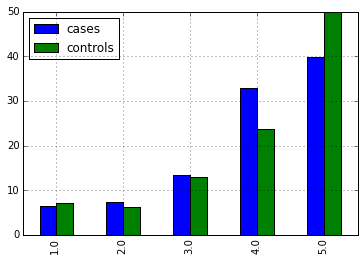

In [195]:
catdist = pd.concat([cases.ix[:,1:11].applymap(jobcatlookup.get).stack().value_counts(),
controls.ix[:,1:11].applymap(jobcatlookup.get).stack().value_counts()], axis=1)
catdist.columns = ['cases', 'controls']
catdist.apply(lambda x: 100*x/float(x.sum())).plot(kind='bar')

In [20]:
caseclass = soc_class_analysis(cases)
contclass = soc_class_analysis(controls)

caseclass = pd.DataFrame(caseclass)
caseclass = caseclass.apply(lambda x: 100*x/float(x.sum()))
#caseclass.sort().plot(kind='bar', title='Percentage of cases in each social class', ylim=(0,30), legend=False)

contclass = pd.DataFrame(contclass)
contclass = contclass.apply(lambda x: 100*x/float(x.sum()))
#contclass.sort().plot(kind='bar', ylim=(0,30), legend=False, title ='Percentage of controls in each social class')

caseclass.columns = ['cases']
contclass.columns = ['controls']
casecont = [caseclass, contclass]

np = pd.concat(casecont, axis=1)
np = pd.concat([np,pd.DataFrame(np.sum(axis=0),columns=['Total']).T]).fillna(0)
np = np.reset_index()
np.columns = ['SEC', '% cases', '% controls']

np

,SEC,% cases,% controls
0,1.1,16.6,27.0
1,1.2,14.3,18.4
2,2.0,19.7,25.5
3,3.0,16.1,12.2
4,4.0,7.6,11.2
5,5.0,7.6,3.1
6,6.0,11.2,2.6
7,7.0,6.7,0.0
8,Total,100.0,100.0


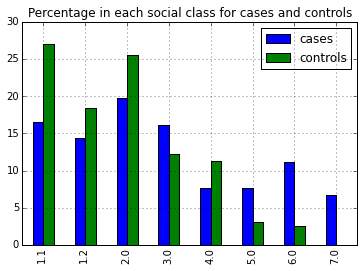

In [21]:
pd.concat(casecont, axis=1).plot(kind='bar', title ='Percentage in each social class for cases and controls')

In [209]:
def whatsinthegroup(groupnum):
    group = groupnum
    socname = pd.DataFrame(jobclassification[group]).applymap(soclookup.get)
    df = pd.concat([pd.DataFrame(jobclassification[group]), socname], axis=1)
    df.columns = ['SOC90 code', jobgroups[group]]
    return df

In [210]:
whatsinthegroup(1)

,SOC90 code,Non-construction high risk occupations
0,69,None
1,173,Hotel and accommodation managers
2,174,Restaurant and catering managers
3,239,Other teaching professionals n.e.c.
4,332,Ship and hovercraft officers
5,385,Musicians
6,463,"Radio and telegraph operators, other office co..."
7,533,Sheet metal workers
8,534,"Metal plate workers, shipwrights, riveters"
9,541,Coach and vehicle body builders
